# Chapitre 3 - Expériences statistiques et tests de significativité

In [1]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [2]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [3]:
WEB_PAGE_DATA_CSV = DATA / 'web_page_data.csv'
FOUR_SESSIONS_CSV = DATA / 'four_sessions.csv'
CLICK_RATE_CSV = DATA / 'click_rates.csv'
IMANISHI_CSV = DATA / 'imanishi_data.csv'

Un test d'hypothèse est une procédure statistique qui permet de décider si une hypothèse est vraie ou fausse. Le but est de savoir si le facteur chance est responsable de l'observation d'un événement ou si cet événement est dû à un phénomène réel.

## L'hypothèse nulle (H0) :
L'effet est dû au hasard.


## L'hypothèse alternative (H1) :
L'effet est dû à un phénomène réel.

### Remarque :
 H0 et H1 doivent former l'ensemble des événements possibles

## Conditions de réalisation du test de significativé
Dans un test A/B correctement réalisé, nous collectons des données sur les traitements subis par A et B de telle sorte qu'une différence ne puisse être que le fruit :
    - du hasard lors de l'attribution des groupes
    - une différence vraie entre A et B 
    

## Explications 
"Étant donné la tendance humaine à réagir à un comportement inhabituel mais aléatoire et à l'interpréter comme quelque chose de significatif et réel, dans nos expériences, nous exigerons une preuve que la différence entre les groupes est plus extrême que ce que le hasard pourrait raisonnablement produire."


## Tests d'hypothèses

In [4]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times = pd.DataFrame(session_times)
session_times.Time = 100 * session_times.Time

In [5]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
mean_b - mean_a

35.66666666666667

### Test de Permuation

On voit que la moyenne du temps de chargement de la page B est plus élevée que celle de la page A. Mais est-ce que cette différence est statistiquement significative ? Pour le savoir, on peut effectuer un test de permutation.

In [6]:
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()

Text(0.5, 0.98, '')

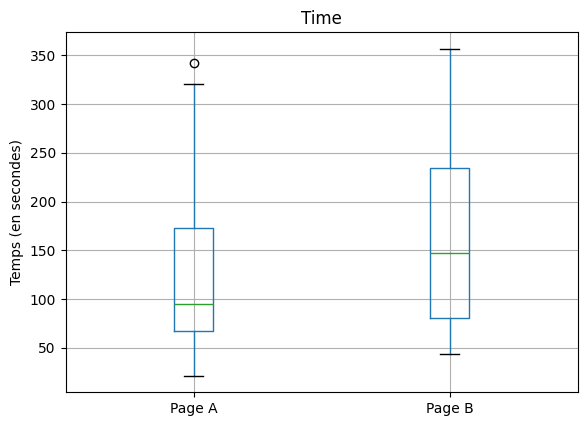

In [7]:
ax = session_times.boxplot(by='Page', column='Time')
ax.set_xlabel('')
ax.set_ylabel('Temps (en secondes)')
plt.suptitle('')

In [8]:
session_times = pd.DataFrame(session_times)

nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]

print(perm_fun(session_times.Time, nA, nB))

4.695238095238096


Text(0, 0.5, 'Fréquence')

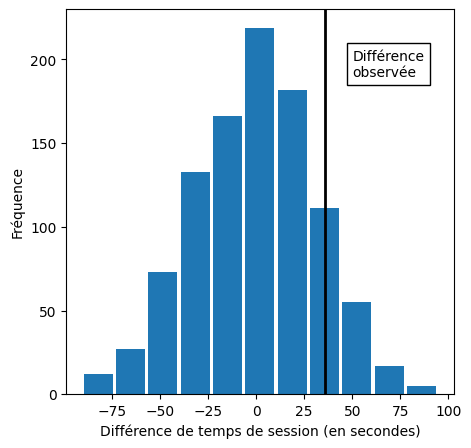

In [9]:
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
ax.text(50, 190, 'Différence\nobservée', bbox={'facecolor':'white'})
ax.set_xlabel('Différence de temps de session (en secondes)')
ax.set_ylabel('Fréquence')


De ce que l'on peut en conclure avec ce résultat, il ne semble pas y avoir de réelle différence entre A et B.

## Significativité Statistique et p-Valeurs

### p-value
Étant donné un modèle de hasard qui incarne l'hypothèse nulle, la p-value est la probabilité d'obtenir des résultats aussi inhabituels ou extrêmes que les résultats observés.

### Alpha
Le seuil de probabilité d'« inhabituel » que les résultats dus au hasard doivent dépasser pour que les résultats réels soient considérés comme statistiquement significatifs.

### Erreur de type 1
Conclusion erronée qu'un effet est réel (alors qu'il est dû au hasard).

### Erreur de type 2
Conclusion erronée qu'un effet est dû au hasard (alors qu'il est réel).


Différence observée: 0.0368%


Text(0, 0.5, 'Fréquence')

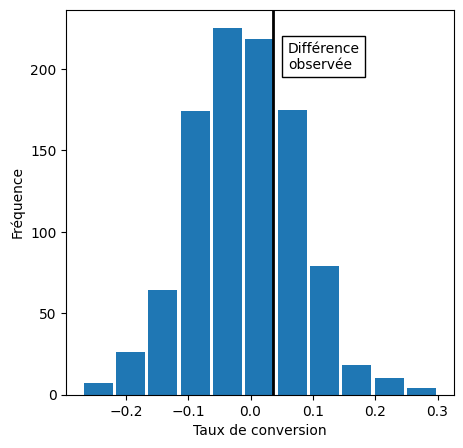

In [10]:
obs_pct_diff = 100 * (200/23739 - 182/22588)
print(f'Différence observée: {obs_pct_diff:.4f}%')

conversion = [0]*45945
conversion.extend([1]*382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = obs_pct_diff, color='black', lw=2)
ax.text(0.06,200, 'Différence\nobservée', bbox={'facecolor':'white'})
ax.set_xlabel('Taux de conversion')
ax.set_ylabel('Fréquence')

### p-Valeur

Définition : La probabilité un model basé sur le hasard puisse donner des résultats aussi extrêmes que ceux observés précedemment.

Rien d'autre ne peut en être déduit, il ne faut pas sur interpréter cette statistique car cela risque de mener à des erreurs grossières.


In [11]:
np.mean([diff > obs_pct_diff for diff in perm_diffs])

0.321

In [12]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-valeur pour un test unilatéral: {p_value / 2:.4f}')

p-valeur pour un test unilatéral: 0.3498


### Alpha 

La valeur alpha, ou niveau de signification, est un seuil fixé à l'avance dans un test statistique pour décider si une différence observée est statistiquement significative ou non.

# Distribution de Gosset (t de Student)

La **distribution de Gosset**, également connue sous le nom de **distribution t de Student**, est une distribution de probabilité utilisée en statistiques lorsqu'on travaille avec des **petits échantillons** et que la **variance de la population est inconnue**.

## Utilisation
La distribution t de Student est utilisée lorsque :
1. La **taille de l'échantillon** est petite (n < 30).
2. La **variance de la population** est inconnue.
3. Les données suivent une **distribution normale** ou approximativement normale.

Elle est principalement utilisée dans les **tests t** :
- **Test t pour un échantillon** : comparer la moyenne d'un échantillon à une valeur hypothétique.
- **Test t pour deux échantillons indépendants** : comparer les moyennes de deux groupes.
- **Test t apparié** : comparer les moyennes de deux mesures sur les mêmes sujets.

## Différence avec la distribution normale
- La **distribution t** a des **queues plus épaisses** que la distribution normale, ce qui permet de mieux modéliser les variations extrêmes dans les petits échantillons.
- À mesure que la taille de l'échantillon augmente, la distribution t devient proche de la **distribution normale**.

## Formule de la statistique t

$
t = \frac{\bar{x} - \mu}{\frac{s}{\sqrt{n}}}
$

- $\bar{x} $ : Moyenne de l'échantillon.
- $\mu $ : Moyenne de la population sous l'hypothèse nulle.
- $ s $ : Écart-type de l'échantillon.
- $ n $ : Taille de l'échantillon.


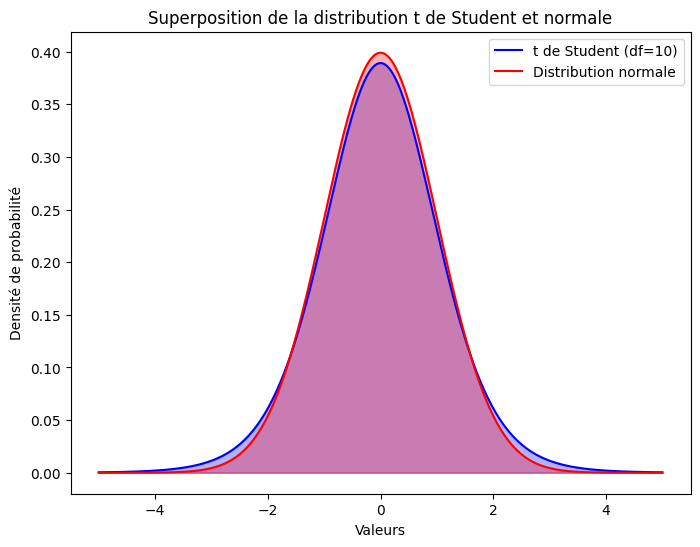

In [13]:
df = 10
mu, sigma = 0, 1

x = np.linspace(-5, 5, 1000)

t_dist = stats.t.pdf(x, df)
normal_dist = stats.norm.pdf(x, mu, sigma)

plt.figure(figsize=(8, 6))

plt.plot(x, t_dist, 'b-', label=f't de Student (df={df})')
plt.fill_between(x, t_dist, color='blue', alpha=0.3)

plt.plot(x, normal_dist, 'r-', label='Distribution normale')
plt.fill_between(x, normal_dist, color='red', alpha=0.3)

plt.title("Superposition de la distribution t de Student et normale")
plt.xlabel('Valeurs')
plt.ylabel('Densité de probabilité')
plt.legend()

plt.show()

In [14]:
res = stats.ttest_ind(session_times[session_times.Page == "Page A"].Time,
                      session_times[session_times.Page == "Page B"].Time,
                      equal_var = False
                      )

print(f" p-Valeur pour un test unilatéral est de {res.pvalue/2:.4f}")

 p-Valeur pour un test unilatéral est de 0.1408


## ANOVA

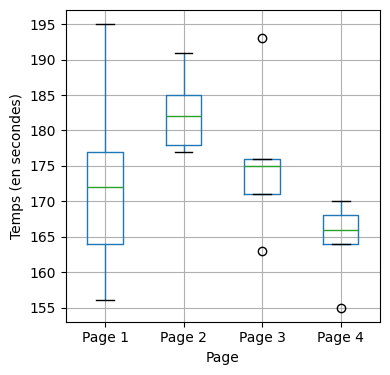

In [15]:
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)

ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('Page')
ax.set_ylabel('Temps (en secondes)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

In [16]:
observed_variance = four_sessions.groupby('Page').mean().var().iloc[0]
print('Moyenne observée:', four_sessions.groupby('Page').mean().values)
print('Variance:', observed_variance)

def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var().iloc[0]

perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('p-Valeur :', np.mean([var > observed_variance for var in perm_variance]))

Moyenne observée: [[172.8]
 [182.6]
 [175.6]
 [164.6]]
Variance: 55.426666666666655
p-Valeur : 0.08233333333333333


## F Statistic et ANOVA



# ANOVA (Analysis of Variance)

L'**ANOVA** (Analyse de la variance) est un test statistique utilisé pour comparer les moyennes de plusieurs groupes et déterminer si elles sont significativement différentes. Ce test est utile lorsque l'on a plus de deux groupes à comparer et qu'on veut savoir si au moins un groupe diffère des autres.

### 1. Hypothèses de l'ANOVA

- **Hypothèse nulle (H₀)** : Toutes les moyennes des groupes sont égales. Il n'y a pas de différence significative entre les groupes.
- **Hypothèse alternative (H₁)** : Au moins une moyenne de groupe est différente des autres.

### 2. Fonctionnement de l'ANOVA

L'ANOVA compare deux types de variances :
- **Variance entre les groupes** : Variation des moyennes entre les différents groupes. C'est l'effet potentiel du traitement ou des différences entre les groupes.
- **Variance à l'intérieur des groupes** : Variation au sein de chaque groupe. Cela représente les différences dues à des facteurs aléatoires ou à des erreurs expérimentales.

Le test calcule un rapport appelé la **F-statistic** :

$
F = \frac{\text{Variance entre les groupes}}{\text{Variance à l'intérieur des groupes}}
$

- Si la variance entre les groupes est beaucoup plus grande que la variance à l'intérieur des groupes, l'**F-statistic** sera élevée, suggérant des différences significatives entre les groupes.
- Si l'F-statistic est faible, cela signifie que les différences entre les groupes peuvent être dues au hasard.


In [17]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()

aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
Page,3.0,831.4,277.133333,2.739825,0.077586
Residual,16.0,1618.4,101.150000,NaN,NaN


# Décomposition de la Variance

En statistique, la **décomposition de la variance** permet de décomposer chaque valeur observée dans un jeu de données en trois composantes : la moyenne générale, l'effet du traitement, et l'erreur résiduelle. Cette méthode est souvent utilisée dans des analyses comme l'ANOVA.

### 1. Moyenne générale (grand average)

La **moyenne générale** est la moyenne de toutes les valeurs observées dans le jeu de données, sans tenir compte des groupes ou des catégories. C'est la tendance centrale globale des données. Par exemple, pour des données sur l'adhérence des pages web, la moyenne générale est :

$
\text{Moyenne générale} = 173.75
$

### 2. Effet du traitement (treatment effect)

L'**effet du traitement** correspond à la différence entre la moyenne d'un groupe spécifique (ou d'une condition) et la moyenne générale. Cet effet peut être positif ou négatif.

Dans l'exemple :
- Moyenne du groupe A = 172
- Effet du traitement = 172 - 173.75 = -1.75

Cela signifie que ce groupe a une moyenne légèrement inférieure à la moyenne générale.

### 3. Erreur résiduelle (residual error)

L'**erreur résiduelle** est la différence entre une valeur observée individuelle et la moyenne de son groupe. Elle représente les variations aléatoires ou les facteurs non expliqués par le traitement.

Dans l'exemple :
- Valeur observée = 164
- Moyenne du groupe = 172
- Erreur résiduelle = 164 - 172 = -8

Cela montre que cette valeur est en-dessous de la moyenne du groupe.

### 4. Exemple de Décomposition de la Variance

Prenons l'exemple de la première valeur observée dans un test A/B/C/D :

- **Moyenne générale** : 173.75
- **Effet du traitement (groupe A)** : -1.75
- **Erreur résiduelle** : -8

On peut décomposer la valeur observée de la manière suivante :

$
\text{Valeur observée} = \text{Moyenne générale} + \text{Effet du traitement} + \text{Erreur résiduelle}
$
$
164 = 173.75 + (-1.75) + (-8)
$


## Test du Chi-carré

Supposons que vous testiez trois titres différents—A, B et C—et que vous les présentez chacun à 1 000 visiteurs, avec les résultats affichés dans le tableau ci-dessous.

| **Titre** | **Click** | **No-click** |
|-----------|------------|---------------|
| A         | 14         | 986           |
| B         | 8          | 992           |
| C         | 12         | 988           |

Les titres semblent différer. Par exemple, le titre A génère presque deux fois plus de clics que le titre B. Cependant, les chiffres sont petits, donc une procédure de rééchantillonnage est nécessaire pour tester si ces différences de taux de clics sont plus importantes que ce que le hasard pourrait provoquer.

### Hypothèse Nulle

L'hypothèse nulle (**H₀**) est que tous les titres partagent le même taux de clics global, qui serait de **34 clics sur 3 000 visiteurs**. Si cette hypothèse est vraie, la distribution attendue des clics est présentée dans le tableau suivant.

| **Titre** | **Click (Attendu)** | **No-click (Attendu)** |
|-----------|---------------------|------------------------|
| A         | 11.33               | 988.67                 |
| B         | 11.33               | 988.67                 |
| C         | 11.33               | 988.67                 |

### Calcul des Résidus de Pearson

Les **résidus de Pearson** mesurent l'écart entre les valeurs observées et les valeurs attendues sous l'hypothèse nulle. Les résidus pour chaque titre sont donnés dans le tableau suivant.

$
R = \frac{O - E}{\sqrt{E}}
$


| **Titre** | **Click** | **No-click** |
|-----------|-----------|--------------|
| A         | 0.792     | -0.085       |
| B         | -0.990    | 0.106        |
| C         | 0.198     | -0.021       |

## Statistique du Chi-carré

La **statistique du Chi-carré** est définie comme la somme des résidus de Pearson au carré. Elle est calculée ainsi :

$
\chi^2 = \sum_{i=1}^{r} \sum_{j=1}^{c} R_{ij}^2
$

où **r** est le nombre de lignes et **c** le nombre de colonnes.

Dans cet exemple, la statistique du Chi-carré est **1.666**.



In [18]:
# Table 3-4
click_rate = pd.read_csv(CLICK_RATE_CSV)
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
print(clicks)

# Table 3-5
row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


In [19]:
# Resampling approach
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [expected_clicks, expected_noclicks]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    random.shuffle(box)
    sample_clicks = [sum(box[0:1000]),
                     sum(box[1000:2000]),
                     sum(box[2000:3000])]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'chi2 observé: {chi2observed:.4f}')
print(f'p-valeur aprés re-échantillonage: {resampled_p_value:.4f}')

chi2 observé: 1.6659
p-valeur aprés re-échantillonage: 0.4765


In [20]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'chi2 observé: {chi2observed:.4f}')
print(f'p-Valeur: {pvalue:.4f}')

chi2 observé: 1.6659
p-Valeur: 0.4348


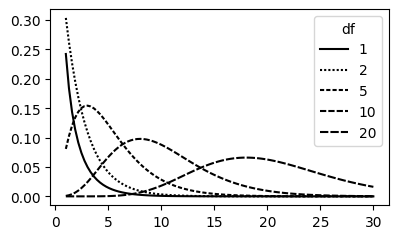

In [21]:
x = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pd.DataFrame({
    'x': x,
    'chi_1': stats.chi2.pdf(x, df=1),
    'chi_2': stats.chi2.pdf(x, df=2),
    'chi_5': stats.chi2.pdf(x, df=5),
    'chi_10': stats.chi2.pdf(x, df=10),
    'chi_20': stats.chi2.pdf(x, df=20),
})
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(chi.x, chi.chi_1, color='black', linestyle='-', label='1')
ax.plot(chi.x, chi.chi_2, color='black', linestyle=(0, (1, 1)), label='2')
ax.plot(chi.x, chi.chi_5, color='black', linestyle=(0, (2, 1)), label='5')
ax.plot(chi.x, chi.chi_10, color='black', linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='black', linestyle=(0, (4, 1)), label='20')
ax.legend(title='df')

plt.tight_layout()
plt.show()

# Test de véracité de Fisher

In [22]:
#stats.fisher_exact(clicks.values)

# Que pour des matrices 2x2

# Fraude dans la Science

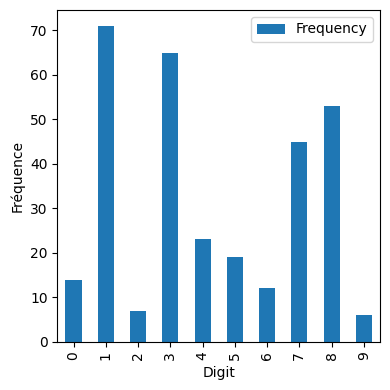

In [23]:
imanishi = pd.read_csv(IMANISHI_CSV)
imanishi.columns = [c.strip() for c in imanishi.columns]
ax = imanishi.plot.bar(x='Digit', y=['Frequency'],figsize=(4, 4))
ax.set_xlabel('Digit')
ax.set_ylabel('Fréquence')

plt.tight_layout()
plt.show()

Les données sont censées suivre une distribution normale, or, on voit très bien ici qu'elle ne la suive pas. Elles ont donc été générées avec biais.

# Algorithme du bandit manchot

Le **Multi-Arm Bandit** offre une approche pour les tests, en particulier les tests web, permettant une optimisation explicite et une prise de décision plus rapide que l'approche statistique traditionnelle utilisée dans la conception d'expériences.

## Termes Clés du Multi-Arm Bandit
- **Multi-Arm Bandit** : Une machine à sous imaginaire avec plusieurs bras à choisir, chacun ayant des gains différents, utilisée comme analogie pour une expérience multi-traitement.
- **Arm (Bras)** : Un traitement dans une expérience (par exemple, "headline A dans un test web").
- **Win (Gagné)** : L'analogie expérimentale d'un gain à la machine à sous (par exemple, "le client clique sur le lien").

## Limites du Test A/B Traditionnel
Un test A/B traditionnel implique de collecter des données dans le cadre d'une expérience pour répondre à une question spécifique, telle que "Quel traitement est meilleur, A ou B ?". Cependant, cette approche présente plusieurs limites :
1. **Résultat Inconclusif** : Les résultats peuvent suggérer un effet sans avoir un échantillon suffisant pour prouver statistiquement cet effet.
2. **Exploitation des Résultats Avant la Fin** : Dans certains cas, il est souhaitable de commencer à tirer parti des résultats avant la fin de l'expérience.
3. **Flexibilité** : Après l'expérience, il peut être nécessaire de réévaluer les décisions à la lumière de nouvelles données. L'approche traditionnelle manque de cette flexibilité.

Avec l'avènement de la puissance de calcul et des logiciels modernes, des approches plus puissantes et flexibles comme les **bandit algorithms** sont désormais possibles, offrant une alternative plus rapide et plus adaptée à l'optimisation des efforts et des résultats globaux.

## Algorithmes Bandits Multi-Bras
Les **bandit algorithms** permettent de tester plusieurs traitements en parallèle et d'arriver à des conclusions plus rapidement que les méthodes traditionnelles. Ils tirent leur nom des machines à sous à bras, souvent appelées "one-armed bandits". Si l’on imagine une machine avec plusieurs bras, chacun ayant un taux de récompense différent, cela correspond au problème du **multi-armed bandit**.

L'objectif est d'identifier et de sélectionner le bras gagnant le plus tôt possible. Le défi est qu'on ne connaît pas à l'avance le taux de gain de chaque bras ; on ne connaît que les résultats des tirages individuels. 

### Exemple de Résultats :
- **Bras A** : 10 victoires sur 50 essais
- **Bras B** : 2 victoires sur 50 essais
- **Bras C** : 4 victoires sur 50 essais

### Stratégies Extrêmes :
1. **Exploitation Pure** : Si le bras A semble meilleur après un petit échantillon, on pourrait arrêter d’essayer les autres bras et se concentrer uniquement sur A. Cependant, cela risque de masquer une performance potentiellement supérieure de B ou C.
2. **Exploration Pure** : On continue à tirer de manière égale sur tous les bras, mais cela risque de perdre du temps avec des traitements moins rentables.

Les **bandit algorithms** trouvent un compromis : on commence à tirer plus fréquemment sur A tout en continuant à explorer B et C. Si B ou C commence à surpasser A, les tirages s'ajusteront en conséquence.

## Application aux Tests Web
Plutôt que des bras de machines à sous, on peut avoir différentes offres, titres ou couleurs sur un site web. Initialement, les offres sont affichées de manière aléatoire. Mais si une offre commence à surpasser les autres, elle est affichée plus souvent.

### Algorithme Epsilon-Greedy
Un algorithme simple pour ajuster les taux d'affichage est l'**epsilon-greedy** :
1. Générer un nombre aléatoire entre 0 et 1.
2. Si ce nombre est inférieur à epsilon, tirer au sort entre les offres. Sinon, montrer l'offre ayant le meilleur taux de réponse.

Epsilon contrôle le degré d'exploration : un epsilon élevé signifie plus d'exploration, tandis qu'un epsilon faible se concentre sur l'exploitation du meilleur bras.

### Algorithme Thompson Sampling
Un algorithme plus sophistiqué est le **Thompson Sampling**, qui utilise une approche bayésienne pour sélectionner l'action qui maximise la probabilité d'un gain en fonction des observations accumulées. Une distribution initiale (par exemple, une distribution bêta) est mise à jour à chaque tirage pour améliorer l'optimisation des choix futurs.

## Avantages des Bandit Algorithms
- Ils permettent de réduire l'exposition aux traitements inférieurs.
- Ils facilitent le traitement de plus de deux traitements à la fois.
- Ils modifient progressivement les probabilités d'échantillonnage pour maximiser les gains globaux.


# Puissance et taille d'échantillon

### Taille de l'effet (Effect Size)
La **taille de l'effet** est la taille minimale de l'effet que l'on espère pouvoir détecter dans un test statistique, comme par exemple "une amélioration de 20 % des taux de clics."

### Puissance (Power)
La **puissance** d'un test statistique est la probabilité de détecter un effet de taille donnée avec une taille d'échantillon spécifique.

### Niveau de Signification (Significance Level)
Le **niveau de signification** statistique est le seuil auquel le test est effectué pour déterminer si les résultats observés sont suffisamment inhabituels pour rejeter l'hypothèse nulle.


In [26]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size,
                              alpha=0.05, power=0.8, alternative='larger')
print('Taille de l échantillon Size: %.3f' % result)

Taille de l échantillon Size: 13358.883
